# **MLS 1 Case Study - CNNs**

### **Context**

**CIFAR-10** (Canadian Institute For Advanced Research) is a **collection of images with 10 different classes** representing airplanes, cars, birds, cats, deer, dogs, frogs, horses, ships, and trucks. **CIFAR-10 is a set of images that can be used to teach a computer how to recognize objects.**

The CIFAR-10 dataset consists of 60000 32x32x3 i.e. color images in 10 classes, with 6000 images per class. There are 50000 training images and 10000 test images. You can learn more about this dataset here - https://www.cs.toronto.edu/~kriz/cifar.html

Since the images in CIFAR-10 are of low-resolution (32x32x3), this dataset can allow researchers to quickly try different algorithms to see what works. Various kinds of convolutional neural networks tend to be the best at recognizing the images in CIFAR-10.

### **Objective**

In this case study, we will build a multi-class classification algorithm to predict 10 different classes of the CIFAR-10 dataset using **Convolutional Neural Networks**

### **Loading Libraries**

In [ ]:
import keras
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf

# Keras Sequential Model
from tensorflow.keras.models import Sequential

# Importing all the different layers and optimizers
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, BatchNormalization, Activation, LeakyReLU
from tensorflow.keras.optimizers import Adam

### **Importing and loading the CIFAR dataset**

The CIFAR dataset is already present in the Keras library in the form of an n-dimensional NumPy array. We will download this dataset from the Keras module here.

In [ ]:
from keras.datasets import cifar10
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

170508288/170498071 [==============================] - 22s 0us/step


In [ ]:
x_train.shape

(50000, 32, 32, 3)

Here the data is stored in a **4-dimensional NumPy array**. The first dimension **50000** is denoting **the number of images in the training data**, and each image is stacked on top of the other as a 3-dimensional NumPy array. The second dimension **32** is denoting **the number of pixels along the x-axis**, **the third dimension 32 is denoting the number of pixels along the y-axis** and **the fourth dimension 3 is the total number of channels in those images** i.e. these are colored images consisting of RGB (Red, Green, and Blue) channels.

Below is a 3-dimensional NumPy representation of the first image in the training data. **Each pixel in an image has 3 values - the intensity of R, G, and B channels**, and the size of each image is 32x32. So, each image is represented by 32 arrays of shape 32x3.

In [ ]:
x_train[0]

array([[[ 59,  62,  63],
        [ 43,  46,  45],
        [ 50,  48,  43],
        ...,
        [158, 132, 108],
        [152, 125, 102],
        [148, 124, 103]],

       [[ 16,  20,  20],
        [  0,   0,   0],
        [ 18,   8,   0],
        ...,
        [123,  88,  55],
        [119,  83,  50],
        [122,  87,  57]],

       [[ 25,  24,  21],
        [ 16,   7,   0],
        [ 49,  27,   8],
        ...,
        [118,  84,  50],
        [120,  84,  50],
        [109,  73,  42]],

       ...,

       [[208, 170,  96],
        [201, 153,  34],
        [198, 161,  26],
        ...,
        [160, 133,  70],
        [ 56,  31,   7],
        [ 53,  34,  20]],

       [[180, 139,  96],
        [173, 123,  42],
        [186, 144,  30],
        ...,
        [184, 148,  94],
        [ 97,  62,  34],
        [ 83,  53,  34]],

       [[177, 144, 116],
        [168, 129,  94],
        [179, 142,  87],
        ...,
        [216, 184, 140],
        [151, 118,  84],
        [123,  92,  72]]

In [ ]:
y_train[0]

array([6], dtype=uint8)

The target labels are encoded in numerical format. Here the encoding 6 denotes the category frog. **We will create a list of category names to convert the number to its original category name.**

In [ ]:
x_test.shape

(10000, 32, 32, 3)

- There are **10,000 images in the test data**.

### **Converting NumPy arrays to images and visualizing some random images**

As we have observed that all the images are stored as NumPy arrays, and values in the array denote the pixel intensities of the image. We can use matplotlib's **imshow** function to visualize the image from NumPy arrays. we are trying to visualize the data by plotting some random images.

In [ ]:
num_classes = 10

# creating a list of category names in alphabetical order
cifar10_classes = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]

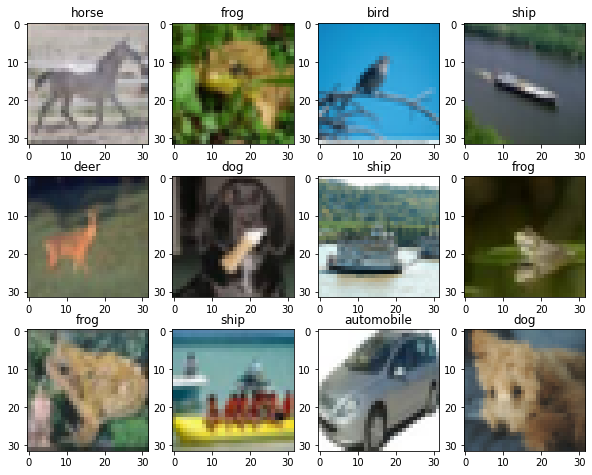

In [ ]:
rows = 3
cols = 4
fig = plt.figure(figsize=(10, 8))
for i in range(cols):
    for j in range(rows):
        random_index = np.random.randint(0, len(y_train))
        ax = fig.add_subplot(rows, cols, i * rows + j + 1)
        ax.imshow(x_train[random_index, :])
        ax.set_title(cifar10_classes[y_train[random_index, 0]])
plt.show()

### **Data Preparation**

In neural networks, it is always suggested to **normalize the feature inputs**. Normalization has the below benefits while training the model of a neural network: 

1. **Normalization makes the training faster and reduces the chances of getting stuck at local optima.**
2. **weight decay and estimation can be done more conveniently** with normalized inputs.
3. In deep neural networks, **normalization helps to avoid exploding gradient problems.** Exploding Gradients problem occurs when large error gradients accumulate and result in very large updates to neural network model weights during training. This makes a model unstable and unable to learn from the training data.

As we know image pixel **values range from 0-255**, here we are simply **dividing all the pixel values by 255 to standardize all the images to have their pixel values between 0-1.**

In [ ]:
# Normalizing the image pixels
x_train_normalized = x_train/255
x_test_normalized = x_test/255

Since this is a **10 class classification problem**, the output layer should have **10 neurons** which will provide us with the probabilities of the input image belonging to each of those 10 classes. Therefore, we also need to create a **one-hot encoded representation for the target classes.**

In [ ]:
# Creating one-hot encoded representation of target labels
# we can do this by using this utility function - https://www.tensorflow.org/api_docs/python/tf/keras/utils/to_categorical

y_train_encoded = tf.keras.utils.to_categorical(y_train)
y_test_encoded = tf.keras.utils.to_categorical(y_test)

### **Model Building**

Let's now create a CNN model sequentially where we will be adding the layers one after another.

First, let's **set the seed for random number generators in NumPy, Python, and TensorFlow** to be able to reproduce the same results every time we run the code.

In [ ]:
#Fixing the seed for random number generators
np.random.seed(42)
import random
random.seed(42)
tf.random.set_seed(42)

Let's build a **CNN model with Leaky Rectified Linear Unit (LeakyRelu)** as the activation function. LeakyReLU is a type of activation function based on a ReLU, but it has a small slope for negative values instead of a flat slope. The slope coefficient is determined before training, i.e. it is not learned during training.

**Note:**
- In Keras, The input features are 4-dimensional for a Conv2D layer.
- Here, we already have 4-dimensional input as these are colored images.
- In the case of grayscale images, we must reshape the input features to specifically define that we have only 1 channel i.e. gray

In [ ]:
# Intializing a sequential model
model_1 = Sequential()

# Adding first conv layer with 64 filters and kernel size 3x3 , padding 'same' provides the output size same as the input size
# Input_shape denotes input image dimension of MNIST images
model_1.add(Conv2D(64, (3, 3), activation='relu', padding="same", input_shape=(32, 32, 3)))

# Adding max pooling to reduce the size of output of first conv layer
model_1.add(MaxPooling2D((2, 2), padding = 'same'))

model_1.add(Conv2D(32, (3, 3), activation='relu', padding="same"))
model_1.add(MaxPooling2D((2, 2), padding = 'same'))
model_1.add(Conv2D(32, (3, 3), activation='relu', padding="same"))
model_1.add(MaxPooling2D((2, 2), padding = 'same'))

# flattening the output of the conv layer after max pooling to make it ready for creating dense connections
model_1.add(Flatten())

# Adding a fully connected dense layer with 100 neurons    
model_1.add(Dense(100, activation='relu'))

# Adding the output layer with 10 neurons and activation functions as softmax since this is a multi-class classification problem  
model_1.add(Dense(10, activation='softmax'))

# Using Adam Optimizer
opt = Adam()

# Compile model
model_1.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
# printing the model summary
model_1.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 32, 32, 64)        1792      
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 16, 16, 64)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 16, 16, 32)        18464     
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 8, 8, 32)         0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 8, 8, 32)          9248      
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 4, 4, 32)        

As we can see from the above summary, this CNN model will train and learn **81,814 parameters (weights and biases).**

Let's now compile and train the model using the train data. Here, we are using the loss function - **categorical_crossentropy** as this is a multi-class classification problem. We will try to minimize this loss at every iteration using the **optimizer** of our choice. Also, we are choosing **accuracy** as the metric to measure the performance of the model.

In [ ]:
model_1.compile(
    loss='categorical_crossentropy',
    optimizer=opt, # here we are starting with 0.005 learning rate, by default it is 0.001
    metrics=['accuracy']
)

In [ ]:
history_1 = model_1.fit(
            x_train_normalized, y_train_encoded,
            epochs=10,
            validation_split=0.1
)

Epoch 1/10
1407/1407 [==============================] - 46s 32ms/step - loss: 1.5077 - accuracy: 0.4527 - val_loss: 1.2015 - val_accuracy: 0.5724
Epoch 2/10
1407/1407 [==============================] - 46s 33ms/step - loss: 1.1294 - accuracy: 0.6007 - val_loss: 1.0082 - val_accuracy: 0.6472
Epoch 3/10
1407/1407 [==============================] - 46s 33ms/step - loss: 0.9848 - accuracy: 0.6549 - val_loss: 0.9229 - val_accuracy: 0.6784
Epoch 4/10
1407/1407 [==============================] - 47s 34ms/step - loss: 0.8864 - accuracy: 0.6898 - val_loss: 0.8806 - val_accuracy: 0.7008
Epoch 5/10
1407/1407 [==============================] - 49s 35ms/step - loss: 0.8191 - accuracy: 0.7128 - val_loss: 0.8255 - val_accuracy: 0.7106
Epoch 6/10
1407/1407 [==============================] - 51s 36ms/step - loss: 0.7600 - accuracy: 0.7320 - val_loss: 0.8210 - val_accuracy: 0.7160
Epoch 7/10
1407/1407 [==============================] - 55s 39ms/step - loss: 0.7148 - accuracy: 0.7486 - val_loss: 0.8380 -

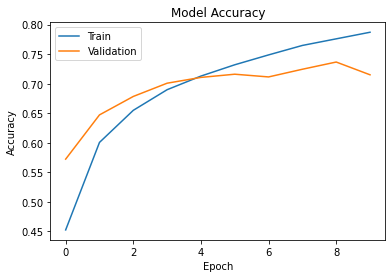

In [ ]:
plt.plot(history_1.history['accuracy'])
plt.plot(history_1.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [ ]:
model_1.evaluate(x_test_normalized, y_test_encoded)

313/313 [==============================] - 1s 4ms/step - loss: 0.9187 - accuracy: 0.6897


[0.9187103509902954, 0.6897000074386597]

**Observations:** 

- We can see that our training accuracy is 78.7% and our Test Accuracy is 69%. 
- In the next steps, we will try to build a more complex model with more CNN layers and see if it increases our Train/Test accuracy.
- We will also try to use dropout in the FC layers at the end to prevent overfitting.


First, we need to clear the previous model's history from the session. In Keras, we need special command to clear the model's history otherwise the previous model history remains in the backend. 

Also, let's fix the seed again after clearing the backend.

Let's now build another model with a few more convolution layers, max-pooling layers, and dropout layers to reduce overfitting.

In [ ]:
#Clearing backend
from tensorflow.keras import backend
backend.clear_session()

In [ ]:
#Fixing the seed for random number generators
np.random.seed(42)
import random
random.seed(42)
tf.random.set_seed(42)

In [ ]:
# Intializing a sequential model
model_2 = Sequential()

# Adding first conv layer with 64 filters and kernel size 3x3 , padding 'same' provides the output size same as the input size
# Input_shape denotes input image dimension of MNIST images
model_2.add(Conv2D(64, (3, 3), activation='relu', padding="same", input_shape=(32, 32, 3)))
model_2.add(Conv2D(64, (3, 3), activation='relu', padding="same"))
# Adding max pooling to reduce the size of output of first conv layer
model_2.add(MaxPooling2D((2, 2), padding = 'same'))

model_2.add(Conv2D(32, (3, 3), activation='relu', padding="same"))
model_2.add(Conv2D(32, (3, 3), activation='relu', padding="same"))
model_2.add(MaxPooling2D((2, 2), padding = 'same'))
model_2.add(Conv2D(32, (3, 3), activation='relu', padding="same"))
model_2.add(Conv2D(32, (3, 3), activation='relu', padding="same"))
model_2.add(MaxPooling2D((2, 2), padding = 'same'))

# flattening the output of the conv layer after max pooling to make it ready for creating dense connections
model_2.add(Flatten())

# Adding a fully connected dense layer with 100 neurons    
model_2.add(Dense(128, activation='relu'))
model_2.add(Dropout(0.25))
model_2.add(Dense(64, activation='relu'))
# Adding the output layer with 10 neurons and activation functions as softmax since this is a multi-class classification problem  
model_2.add(Dense(10, activation='softmax'))

# Using Adam Optimizer
opt = Adam()

# Compile model
model_1.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
#printing the model summary
model_2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 32, 32, 64)        1792      
                                                                 
 conv2d_5 (Conv2D)           (None, 32, 32, 64)        36928     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 16, 16, 64)       0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 16, 16, 32)        18464     
                                                                 
 conv2d_7 (Conv2D)           (None, 16, 16, 32)        9248      
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 8, 8, 32)         0         
 2D)                                                  

In [ ]:
# Compiling the model
model_2.compile(
    loss='categorical_crossentropy',
    optimizer=opt, 
    metrics=['accuracy']
)

In [ ]:
# Fitting the model
history_2 = model_2.fit(
            x_train_normalized, y_train_encoded,
            epochs=10,
            validation_split=0.1
)

Epoch 1/10
1407/1407 [==============================] - 242s 172ms/step - loss: 1.3768 - accuracy: 0.4985 - val_loss: 1.1999 - val_accuracy: 0.5586
Epoch 2/10
1407/1407 [==============================] - 224s 159ms/step - loss: 1.1247 - accuracy: 0.5974 - val_loss: 0.9708 - val_accuracy: 0.6562
Epoch 3/10
1407/1407 [==============================] - 207s 147ms/step - loss: 0.9866 - accuracy: 0.6493 - val_loss: 0.9376 - val_accuracy: 0.6788
Epoch 4/10
1407/1407 [==============================] - 202s 143ms/step - loss: 0.9000 - accuracy: 0.6821 - val_loss: 0.8467 - val_accuracy: 0.7016
Epoch 5/10
1407/1407 [==============================] - 211s 150ms/step - loss: 0.8285 - accuracy: 0.7067 - val_loss: 0.7869 - val_accuracy: 0.7288
Epoch 6/10
1407/1407 [==============================] - 222s 158ms/step - loss: 0.7764 - accuracy: 0.7292 - val_loss: 0.7880 - val_accuracy: 0.7244
Epoch 7/10
1407/1407 [==============================] - 213s 152ms/step - loss: 0.7287 - accuracy: 0.7434 - val_

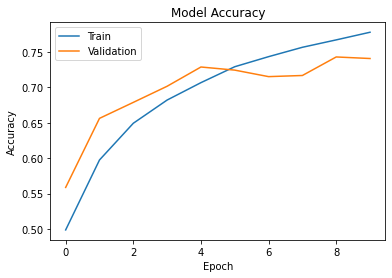

In [ ]:
plt.plot(history_2.history['accuracy'])
plt.plot(history_2.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [ ]:
model_2.evaluate(x_test_normalized, y_test_encoded)

313/313 [==============================] - 7s 23ms/step - loss: 0.8312 - accuracy: 0.7146


[0.8312354683876038, 0.7146000266075134]

**Observations:** 

- We can see that our training accuracy is 78% and our Test Accuracy is 71%. 
- The second model with dropout layers seems to have reduced the overfitting as compared to the previous model.
- The validation and test accuracy have increased slightly as compared to the previous model.
- Using more convolutions helped us to improve our performance a little.

**We can try out some more iterations and tune some of the hyperparameters** to further improve the model **but hyperparameter tuning is exhaustive** and can take a long time to find the right set of values for each hyperparameter.

## Making Predictions

In [ ]:
#Making predictions on the test data
y_pred_test = model_2.predict(x_test_normalized)

#Converting probabilities to class labels
y_pred_test_classes = np.argmax(y_pred_test, axis=1)

#Calculating the probability of the predicted class
y_pred_test_max_probas = np.max(y_pred_test, axis=1)

              precision    recall  f1-score   support

           0       0.80      0.71      0.75      1000
           1       0.87      0.84      0.85      1000
           2       0.68      0.51      0.58      1000
           3       0.49      0.55      0.52      1000
           4       0.72      0.54      0.61      1000
           5       0.53      0.73      0.62      1000
           6       0.79      0.79      0.79      1000
           7       0.77      0.75      0.76      1000
           8       0.85      0.83      0.84      1000
           9       0.73      0.90      0.81      1000

    accuracy                           0.71     10000
   macro avg       0.72      0.71      0.71     10000
weighted avg       0.72      0.71      0.71     10000



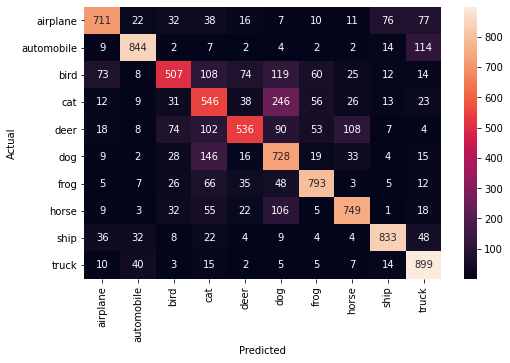

In [ ]:
#importing required functions
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

#Printing the classification report
print(classification_report(y_test, y_pred_test_classes))

#Plotting the heatmap using confusion matrix
cm = confusion_matrix(y_test, y_pred_test_classes)
plt.figure(figsize=(8,5))
sns.heatmap(cm, annot=True,  fmt='.0f', xticklabels=cifar10_classes, yticklabels=cifar10_classes)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

**Observations:**

- The model is giving about **71% accuracy on the test data** which is **comparable to the accuracy of the validation data.** This implies that the model is giving a generalized performance.
- The model is majorly **confused between cats and dogs**. This implies that the **model might be focused on features related to shapes and sizes but not deep features of objects** that can help to distinguish between objects like cats and dogs.
- Consequently, **precision also has a high range with the 'cat' class having the least precision.**
- The **highest precision is for 'automobile'** which implies that the model is able to distinguish automobiles from other objects. 

### **Visualizing predicted images**

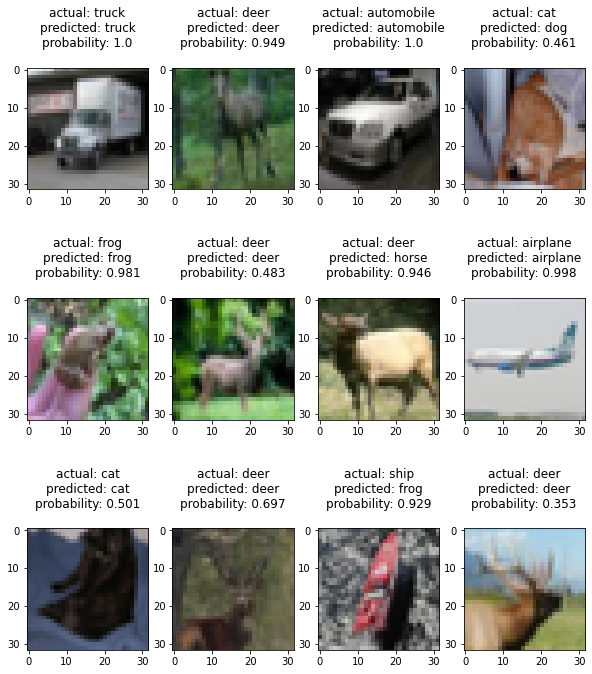

In [ ]:
rows = 3
cols = 4
fig = plt.figure(figsize=(10, 12))
for i in range(cols):
    for j in range(rows):
        random_index = np.random.randint(0, len(y_test))
        ax = fig.add_subplot(rows, cols, i * rows + j + 1)
        ax.imshow(x_test[random_index, :])
        pred_label = cifar10_classes[y_pred_test_classes[random_index]]
        pred_proba = y_pred_test_max_probas[random_index]
        true_label = cifar10_classes[y_test[random_index, 0]]
        ax.set_title("actual: {}\npredicted: {}\nprobability: {:.3}\n".format(
               true_label, pred_label, pred_proba
        ))
plt.show()

### **Conclusion**

In this notebook, **we have implemented a CNN model from scratch to make predictions on the CIFAR-10 dataset.** We have learned how to prepare the image data before passing it into the CNN model and how to add layers sequentially inside the model.

We have seen two different iterations of the CNN model and built an intuition about how to improve the model by tuning various hyperparameters and using different techniques. There is still plenty of scope for improvement and you can try out tuning different hyperparameters to improve the model performance.